In [67]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import S4

# Constants remain the same
h = 6.626070e-34  
c = 2.997925e8    
k_B = 1.380649e-23 
q = 1.602176e-19  
e_0 = 8.8541878128e-12

def Blackbody(lambda_i, T):
    return (2*h*c**2) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**5)*1e14

def nb_B(lambda_i, T):
    return (2*c) / ((np.exp((h*c)/(k_B*T*lambda_i*1e-6))-1)*lambda_i**4)*1e8

def IQE(wavelength, e_g):
    # lambda_g = np.ceil(1240 / e_g) / 1000.0
    # if (lambda_g > wavelength[-1]):
    #     l_index = len(wavelength) - 1
    # else:
    #     l_index = np.where(wavelength >= lambda_g)[0][0]
    # IQE = np.ones(len(wavelength))
    # IQE[l_index:] = 0
    IQE = np.array([1, 0]) # This was created to handle the 1.705, 1.706 micron wavelengths
    return IQE

def JV(em, IQE, lambda_i, T_PV=300):
    J_L = q * np.sum(em * nb_B(lambda_i, 2073.15) * IQE) * (lambda_i[1] - lambda_i[0])
    J_0 = q * np.sum(nb_B(lambda_i, T_PV) * IQE) * (lambda_i[1] - lambda_i[0])

    V_oc = (k_B * T_PV / q) * np.log(J_L / J_0 + 1)
    t = np.linspace(0, 1, 100)
    V = t * V_oc

    J = J_L - J_0 * (np.exp(q * V / (k_B * T_PV)) - 1)
    P = V * J

    return J_L, J_0, V_oc, np.max(P)

def power_ratio(lambda_i, emissivity, T_emitter, E_g_PV=0.726, T_PV=300):
    P_emit = np.sum(emissivity * Blackbody(lambda_i, T_emitter)) * (lambda_i[1] - lambda_i[0])
    IQE_PV = IQE(lambda_i, E_g_PV)
    J_L, J_0, V_oc, P_max = JV(emissivity, IQE_PV, lambda_i, T_PV)
    FOM = J_L / P_emit
    return FOM, J_L, P_emit, J_0, V_oc, P_max

# New function to find latest iteration for a given image
def get_latest_iteration(log_dir, image_index):
    files = os.listdir(log_dir)
    iterations = [int(f.split('.')[1]) for f in files 
                 if f.startswith(f"{image_index}.") and f.endswith('.npy')]
    return max(iterations) if iterations else None

# Load from logs
base_log_dir = os.path.join('..', 'logs')

# Rest of the analysis code remains the same
wavelengths = np.linspace(0.350, 3.0, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]
wavelengths = np.array([1.705, 1.706])
wavelengths = np.linspace(1.650, 1.750, 101)
wavelengths=np.array([.350])
T_e = 2073.15  # K
T_PV = 300     # K
E_g_PV = 0.726 # eV


# Create plots
nb_B_e = nb_B(wavelengths, T_e)
IQE_PV = IQE(wavelengths, E_g_PV)

config = {
    "num_images": int(1),
    "hidden_dimension": int(10),
    "noise_dimension": int(3),
    "seeds": {
        "torch": int(42),
        "numpy": int(42)
    },
    "default_gradient_scale": float(1e2),
    "learning_rate": float(7e-3),
    "binarization_scale": float(1e-11),
    "off_angle": float(45.0),
}

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.noise = torch.rand(
            size=(config['num_images'], config['noise_dimension']))
        self.FC = nn.Sequential(
            nn.Linear(in_features = config['noise_dimension'],
            out_features=100),
        )

    def forward(self):
        output = self.FC(self.noise)
        output = nn.Sigmoid()(output)
        output = output * 1.1 - 0.05
        return torch.clamp(output, min=0.0, max=1.0)


generator = Generator()
generated_images = generator()

In [72]:
n_all = np.load('/home/rliacobacci/Downloads/n_allHTMats.npz')
k_all = np.load('/home/rliacobacci/Downloads/k_allHTMats.npz')

w_n = n_all['arr_0'][:, -1] + k_all['arr_0'][:, -1] * 1j
aln_n = n_all['arr_0'][:, 17] + k_all['arr_0'][:, 17] * 1j

z_step = .1
aln_depth = .473*2
z_max = 3+aln_depth
z_min = -z_step

grating_z_space = torch.linspace(1 + z_step, z_max - 2 - z_step, 4)
grating_x_space = torch.linspace(-0.5, 0.49, 100) + .5  # Every 10nm

harmonics = 14
transmitted_power_per_wavelength = np.zeros(wavelengths.shape[0])
angled_e_fields_per_wavelength = np.zeros((wavelengths.shape[0], grating_z_space.shape[0], grating_x_space.shape[0], 3), dtype=complex)

for i, wavelength in enumerate(wavelengths):
    # TODO: change to 14 when actually using the grating
    S = S4.New(Lattice=((1, 0), (0, 1)), NumBasis=harmonics)

    S.SetMaterial(Name='AluminumNitride', Epsilon=(aln_n[i]) ** 2)
    S.SetMaterial(Name='Tungsten', Epsilon=(w_n[i])**2)
    S.SetMaterial(Name='Vacuum', Epsilon=(1 + 0j)**2)

    S.AddLayer(Name='AirAbove', Thickness=1.5, Material='Vacuum')
    # permittivity_values = generated_images[0] * (aln_n[i]**2 - 1) + 1

    # width = (.5 - -.5) / len(permittivity_values)

    # n_squares = len(permittivity_values)
    # centers = torch.linspace(-.5 + width /
    #                             2, .5 - width / 2, n_squares) + .5

    # S.AddLayer(Name='Grating', Thickness=aln_depth,
    #             Material='AluminumNitride')

    # for q in range(0, 96):
    #     S.SetMaterial(Name=f'Material_{q}', Epsilon=permittivity_values[q].item())
    #     S.SetRegionRectangle(Layer='Grating', Material=f'Material_{q}', Center=(centers[q], 0), Halfwidths=(
    #         # NOTE: if this becomes -1 this works, otherwise it doesn't...??)
    #         1/200, 1 / 2), Angle=0)
    
    S.AddLayer(Name = 'AlN', Thickness = aln_depth, Material='AluminumNitride')

    S.AddLayer(Name='TungstenBelow', Thickness=1, Material='Vacuum')
    S.AddLayer(Name="AirBelow", Thickness=1, Material='Vacuum')

    S.SetExcitationPlanewave(
        IncidenceAngles=(
            # polar angle in [0,180) -- this is the first one that we change for the angular dependence
            config['off_angle'],
            0  # azimuthal angle in [0,360)
        ), sAmplitude=0, pAmplitude=1, Order=0
    )

    S.SetOptions(
        PolarizationDecomposition=True
    )

    S.SetFrequency(1 / float(wavelength))
    (norm_forw, norm_back) = S.GetPowerFluxByOrder(Layer='TungstenBelow', zOffset=0)[0]

    transmitted_power_per_wavelength[i] = np.abs(norm_forw)

    print(f'{np.round(wavelength * 1000)}nm: {transmitted_power_per_wavelength[i]}')
    
    print(S.GetPowerFluxByOrder(Layer = 'AirAbove',  zOffset=0)[1])

    zc = 0
    for z in grating_z_space:
        # TODO: verify that the order of the responses matches the natural order of the x variables
        E, H = S.GetFieldsOnGrid(
            z, NumSamples=(200, 1), Format='Array')
        angled_e_fields_per_wavelength[i][zc] = np.array(E[0])[1::2]
        zc += 1

    del S
    x = len(np.where(np.real(np.mean(np.einsum('ijkl,ijkl->ijk', angled_e_fields_per_wavelength, angled_e_fields_per_wavelength)[i], axis = 0)) > 0)[0])
    y = np.real(np.mean(np.einsum('ijkl,ijkl->ijk', angled_e_fields_per_wavelength, angled_e_fields_per_wavelength)[i], axis = 0))
    if x != 100 and x != 0:
        print("We found one!")

350.0nm: 0.5630732646969361
(0j, 0j)


In [60]:
print(np.mean(np.einsum('ijkl,ijkl->ijk', angled_e_fields_per_wavelength, angled_e_fields_per_wavelength)[0], axis=0))
print(angled_e_fields_per_wavelength.shape)

(4, 100)
(101, 4, 100, 3)


In [6]:
def plot_contour(image_array, title = '', output_path = '', show_plot=False):
    """
    Plot a single image array as a grid of colored squares and save it.
    """
    plt.figure(figsize=(8, 6))
    ax = plt.gca()

    # Check if image_array is 2D
    if image_array.ndim == 1:
        print(f"Image data is 1D with shape {image_array.shape}. Attempting to reshape to 2D.")
        # Attempt to reshape to 2D if possible
        sqrt_len = int(np.sqrt(len(image_array)))
        if sqrt_len * sqrt_len == len(image_array):
            image_array = image_array.reshape((sqrt_len, sqrt_len))
            print(f"Successfully reshaped to 2D with shape {image_array.shape}.")
        else:
            print(f"Cannot reshape image data of length {len(image_array)} to a square 2D array.")
            print("Skipping this image. Ensure your images are 2D or have dimensions that can be reshaped appropriately.")
            plt.close()
            return
    elif image_array.ndim != 2:
        print(f"Unsupported image array with {image_array.ndim} dimensions. Only 2D arrays are supported.")
        plt.close()
        return

    # Define the colormap from white (0) to black (1)
    cmap = plt.cm.gray_r  # 'gray_r' reverses the 'gray' colormap

    # Create the grid of squares with black edges
    try:
        mesh = ax.pcolormesh(image_array, cmap=cmap, edgecolors='black', linewidth=0.1, shading='auto', vmin=0, vmax=1)
    except Exception as e:
        print(f"Failed to create grid plot for {title}: {e}")
        plt.close()
        return

    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    ax.set_aspect('equal')  # Ensure squares are square

    # Remove axis ticks for cleaner look
    ax.set_xticks([])
    ax.set_yticks([])

    # Improve layout
    plt.tight_layout()

    # Save the plot
    # try:
    #     plt.savefig(output_path, dpi=300)
    #     print(f"Saved grid plot to {output_path}")
    # except Exception as e:
    #     print(f"Failed to save plot {output_path}: {e}")

    if show_plot:
        plt.show()
    else:
        plt.close()

# > 1 flux plot

[]

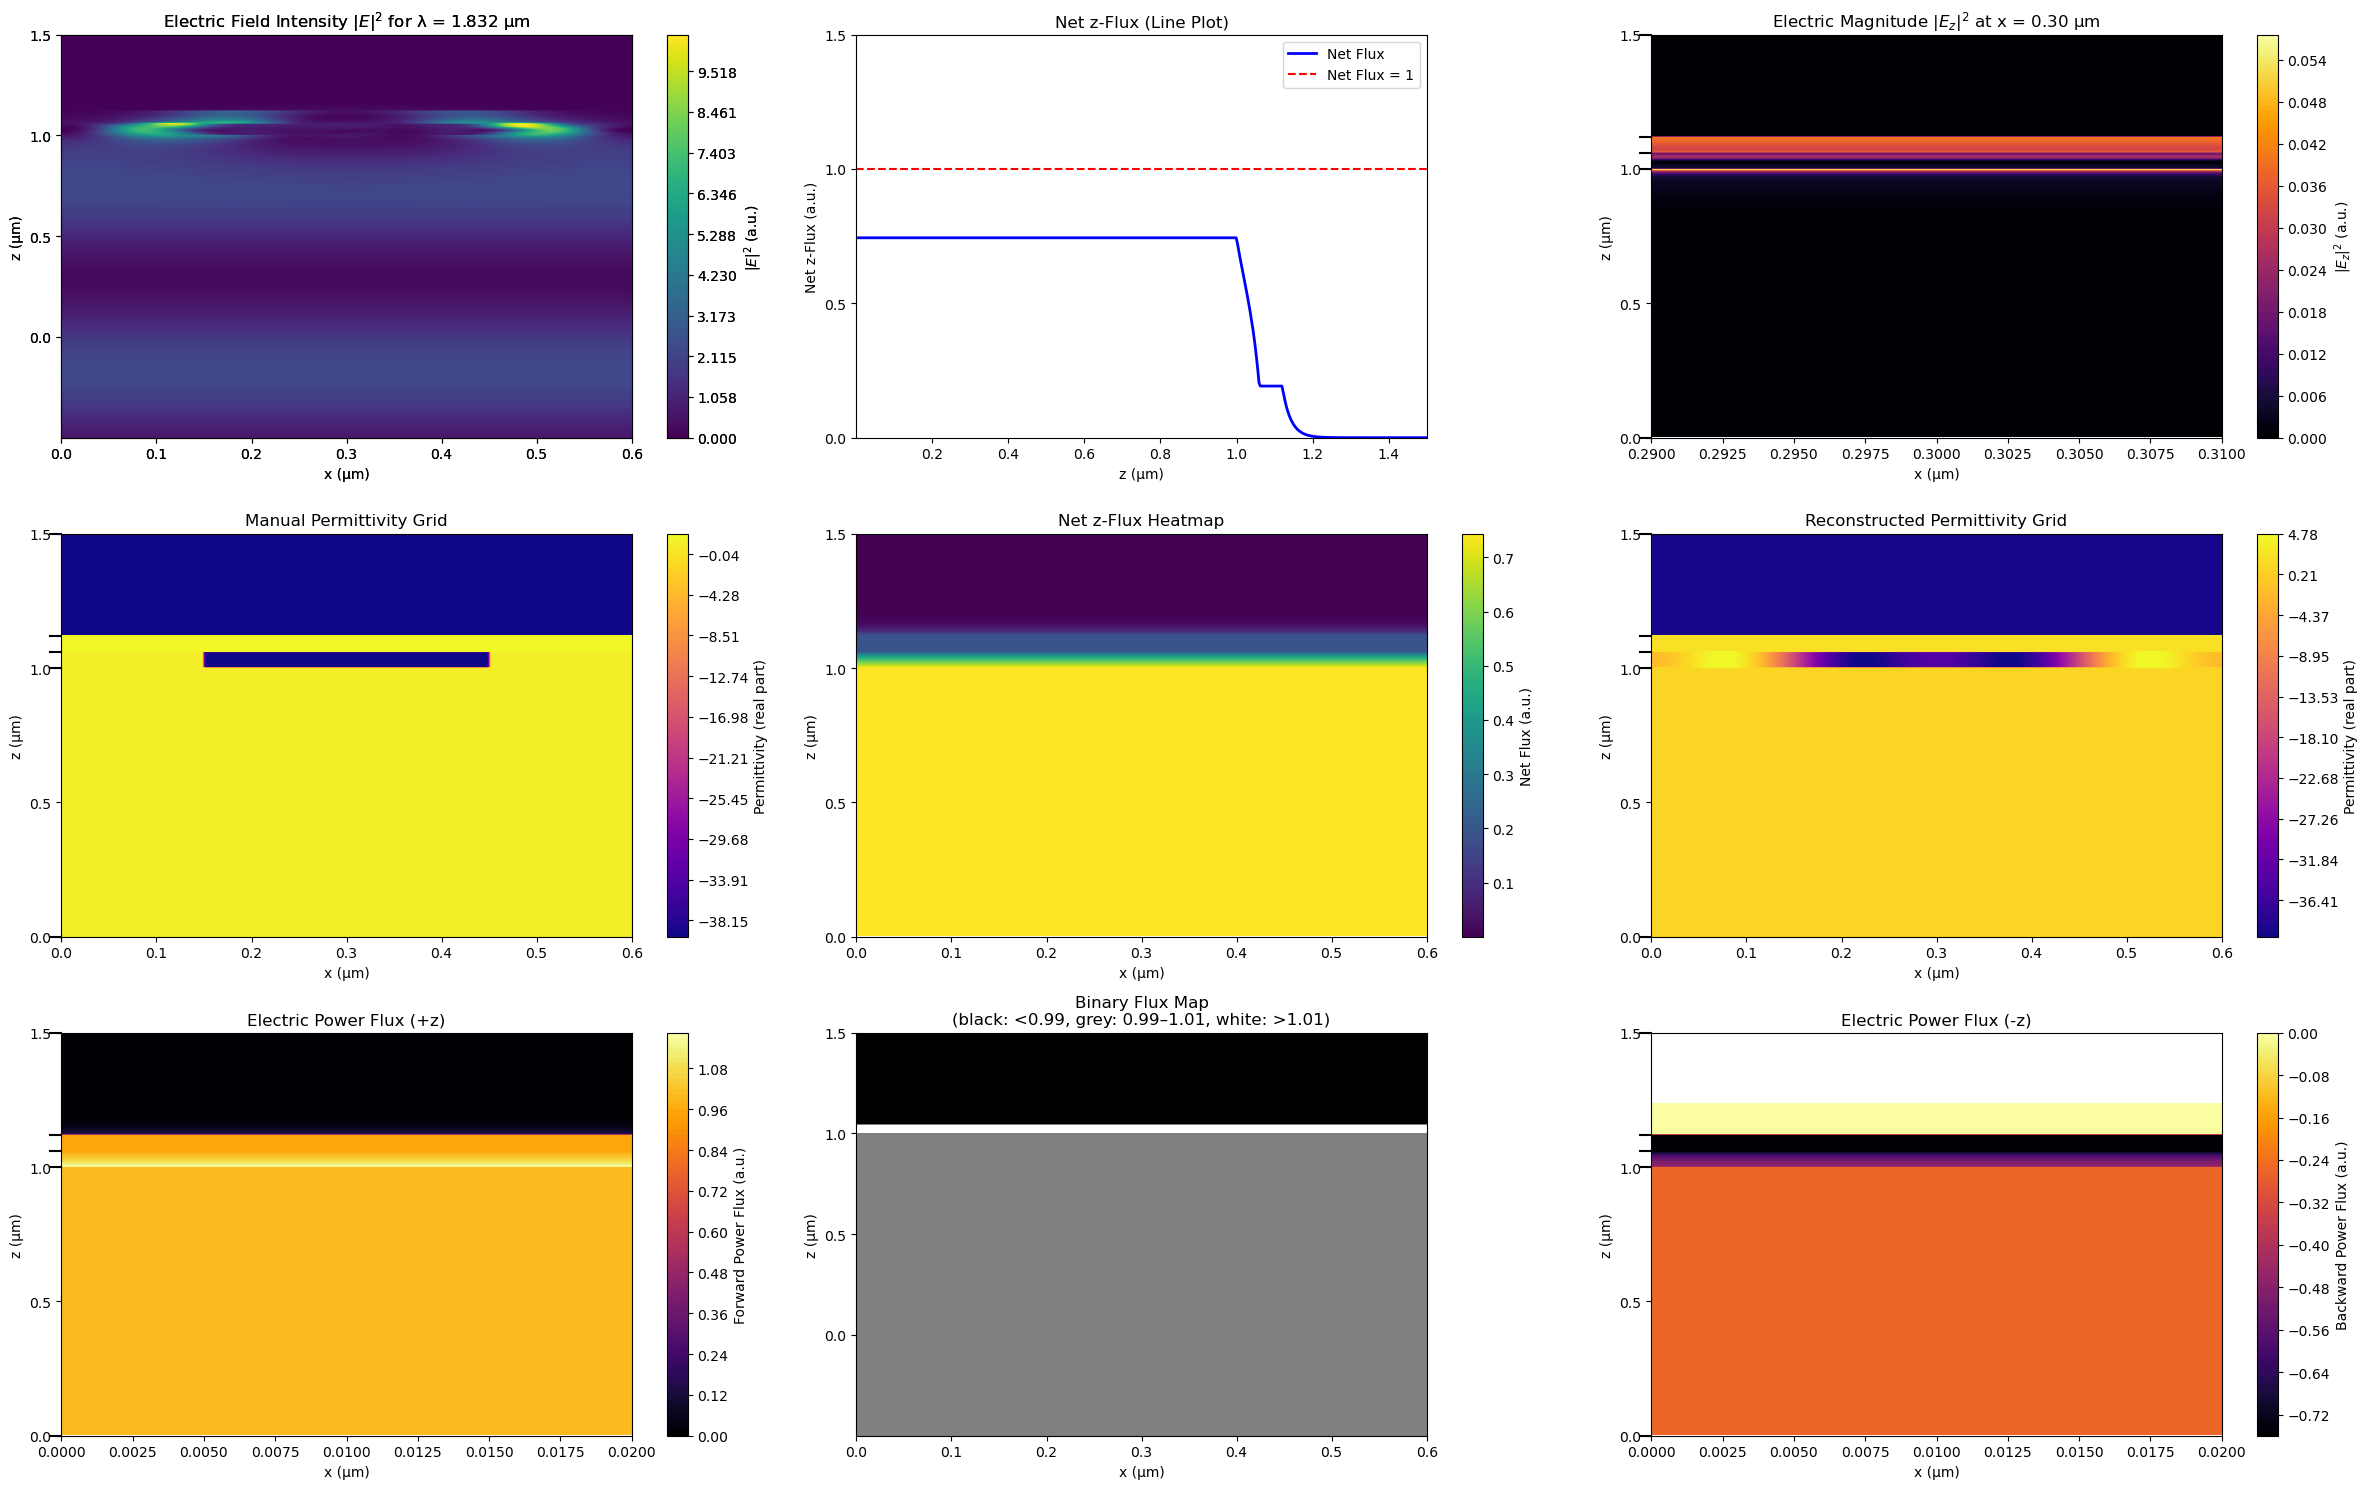

In [2]:
import argparse
import csv
import hashlib
import itertools
import json
import os
import sys
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import S4
import torch
from scipy.interpolate import CubicSpline
from matplotlib.colors import ListedColormap

# =============================================================================
# Configuration parameters for the simulation.
# =============================================================================
config = {
    "seeds": {"torch": 42, "numpy": 42},
    "off_angle": 0.0,
    "square_x_location": 0.15,
    "square_y_location": 0.15,
    "polarization_angle": 30,
    "square_half_widths": 0.15,
    "wavelength_start_index": 0,
    "wavelength_end_index": 2649,
    "measurement_location": 5,
}

save = True

# =============================================================================
# Define the common simulation parameters.
# Top row: z-domain is -0.50 to 1.50 µm.
# Lower plots: data for 0.00 to 1.50 µm.
# =============================================================================
z_min = -0.5
z_max = 1.5
n_z_points = 600  # number of grid points in z
z_space = np.linspace(z_min, z_max, n_z_points)
# For lower plots, only use data for z >= 0.
indices = z_space >= 0
z_space_other = z_space[indices]

x_space = np.linspace(0, 0.6, 200)  # x-domain remains unchanged

# =============================================================================
# Load material data and set up the simulation.
# =============================================================================
wavelengths = torch.linspace(0.350, 3, 2651)
wavelengths = wavelengths[(wavelengths != 0.5) & (wavelengths != 1.0)]

n_all = np.load('/home/rliacobacci/Downloads/n_allHTMats.npz')
k_all = np.load('/home/rliacobacci/Downloads/k_allHTMats.npz')

def load_refractive_index_file(filepath):
    """Load refractive index data from a file with columns 'wl n'."""
    wl_list, n_list = [], []
    with open(filepath, "r") as f:
        f.readline()  # skip header
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 2:
                continue
            wl, n_val = parts
            wl_list.append(float(wl))
            n_list.append(float(n_val))
    return np.array(wl_list), np.array(n_list)

def interpolate_refractive_indices(filepath):
    """Interpolate refractive indices over 350 nm to 3000 nm."""
    orig_wl, orig_n = load_refractive_index_file(filepath)
    new_wl_nm = np.arange(350, 3001)  # nm
    new_wl_microns = new_wl_nm / 1000.0
    cs = CubicSpline(orig_wl, orig_n)
    new_n = cs(new_wl_microns)
    return {wl: n_val for wl, n_val in zip(new_wl_nm, new_n)}

y_pt = .3
SiO2_n = interpolate_refractive_indices('/home/rliacobacci/Downloads/SiO2_n.txt')
i = 1480
wavelength = wavelengths[i]
p = 0.6  # lattice period

w_n = n_all['arr_0'][:, -1] + k_all['arr_0'][:, -1] * 1j
aln_n = n_all['arr_0'][:, 17] + k_all['arr_0'][:, 17] * 1j

harmonics = 70 # 70 is sufficient for electric field calulation in the grid structure layer
# Initialize the S4 simulation object.
S = S4.New(Lattice=((p, 0), (0, p)), NumBasis=harmonics)

S.SetMaterial(Name='AluminumNitride', Epsilon=(aln_n[i])**2)
S.SetMaterial(Name='Tungsten', Epsilon=(w_n[i])**2)
S.SetMaterial(Name='Vacuum', Epsilon=(1 + 0j)**2)
S.SetMaterial(Name='SiliconDioxide', Epsilon=(SiO2_n[int(wavelength * 1e3)]**2))

# Define the layered structure.
S.AddLayer(Name='AirAbove', Thickness=1, Material='Vacuum')
S.AddLayer(Name='TungstenGrid', Thickness=0.06, Material='Vacuum')
S.SetRegionRectangle(
    Layer='TungstenGrid',
    Material='Tungsten',
    Center=(config['square_x_location'] + config['square_half_widths'],
            config['square_y_location'] + config['square_half_widths']),
    Halfwidths=(config['square_half_widths'], config['square_half_widths']),
    Angle=0,
)
S.AddLayer(Name='SiliconDioxide', Thickness=0.06, Material='SiliconDioxide')
S.AddLayer(Name='TungstenBelow', Thickness=1, Material='Tungsten')
S.AddLayer(Name='AirBelow', Thickness=1, Material='Vacuum')

S.SetExcitationPlanewave(
    IncidenceAngles=(config['off_angle'], 0),
    sAmplitude=np.cos(config['polarization_angle'] * np.pi / 180),
    pAmplitude=np.sin(config['polarization_angle'] * np.pi / 180),
    Order=0,
)
S.SetOptions(PolarizationDecomposition=True)
S.SetFrequency(1 / float(wavelength))

# =============================================================================
# Field mapping: Compute the electric field on the (x, z) grid.
# Use GetField at every point instead of GetFieldsOnGrid
# =============================================================================
electric_field = np.zeros((len(z_space), len(x_space), 3), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        E, _ = S.GetFields(x, y_pt, z)  # y is 0
        electric_field[zi, xi, :] = np.array(E)
electric_field_magnitude = np.sum(np.abs(electric_field)**2, axis=2)


# =============================================================================
# Define functions for layer determination based on z.
# =============================================================================
def get_layer(z):
    if z < 0:
        return 'vacuum'
    elif 0 <= z < 1:
        return 'airabove'
    elif 1 <= z < 1.06:
        return 'tungstengrid'
    elif 1.06 <= z < 1.12:
        return 'sio2'
    elif 1.12 <= z < 2.12:
        return 'tungstenbelow'
    elif 2.12 <= z <= 2.5:
        return 'airbelow'
    else:
        return 'vacuum'

def get_layer_info(z):
    if z < 0:
        return None, None
    elif 0 <= z < 1:
        return "AirAbove", z
    elif 1 <= z < 1.06:
        return "TungstenGrid", z - 1.0
    elif 1.06 <= z < 1.12:
        return "SiliconDioxide", z - 1.06
    elif 1.12 <= z < 2.12:
        return "TungstenBelow", z - 1.12
    elif 2.12 <= z <= 2.5:
        return "AirBelow", z - 2.12
    else:
        return None, None

# =============================================================================
# Compute the forward and backward electric power flux using S.GetPowerFlux.
# =============================================================================
z_common = np.linspace(z_min, z_max, n_z_points)
indices_flux = z_common >= 0
z_common_other = z_common[indices_flux]

forward_flux = []
backward_flux = []
for z in z_common:
    layer, offset = get_layer_info(z)
    if layer is None:
        forward_flux.append(np.nan)
        backward_flux.append(np.nan)
    else:
        fwd, bwd = S.GetPowerFlux(Layer=layer, zOffset=offset)
        forward_flux.append(fwd)
        backward_flux.append(bwd)
# Replace NaNs and convert to real.
forward_flux = np.nan_to_num(np.array(forward_flux).real, nan=1.0)
backward_flux = np.nan_to_num(np.array(backward_flux).real, nan=1.0)
flux_2d_flux = np.repeat(forward_flux[:, np.newaxis], 2, axis=1)
flux_2d_flux_other = np.repeat(forward_flux[indices_flux][:, np.newaxis], 2, axis=1)
back_flux_2d = np.repeat(backward_flux[:, np.newaxis], 2, axis=1)
back_flux_2d_other = np.repeat(backward_flux[indices_flux][:, np.newaxis], 2, axis=1)
x_flux = np.linspace(0, 0.02, 2)

# =============================================================================
# Compute the electric field z-component magnitude at x = p/2.
# =============================================================================
x_center = p / 2.0
flux_along_z_field = []
for z in z_space:
    E, _ = S.GetFields(x_center, y_pt, z)
    flux_along_z_field.append(np.abs(E[2])**2)
flux_along_z_field = np.array(flux_along_z_field)
flux_2d_field = np.repeat(flux_along_z_field[:, np.newaxis], 2, axis=1)
flux_2d_field_other = np.repeat(flux_along_z_field[indices][:, np.newaxis], 2, axis=1)
x_flux_field = np.linspace(x_center - 0.01, x_center + 0.01, 2)

# =============================================================================
# Compute the manual and reconstructed permittivity maps.
# =============================================================================
eps_map_manual = np.zeros((len(z_space), len(x_space)))
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        layer = get_layer(z)
        if layer in ['airabove', 'airbelow', 'vacuum']:
            eps_map_manual[zi, xi] = 1.0
        elif layer == 'tungstengrid':
            if 0.15 <= x <= 0.45:
                eps_map_manual[zi, xi] = np.real((w_n[i])**2)
            else:
                eps_map_manual[zi, xi] = 1.0
        elif layer == 'sio2':
            eps_map_manual[zi, xi] = (SiO2_n[int(wavelength*1e3)]**2)
        elif layer == 'tungstenbelow':
            eps_map_manual[zi, xi] = np.real((w_n[i])**2)
        else:
            eps_map_manual[zi, xi] = 1.0
eps_map_manual_other = eps_map_manual[indices, :]

eps_map_reconstructed = np.zeros((len(z_space), len(x_space)), dtype=complex)
for zi, z in enumerate(z_space):
    for xi, x in enumerate(x_space):
        eps_map_reconstructed[zi, xi] = S.GetEpsilon(x, y_pt, z)
eps_map_reconstructed_other = eps_map_reconstructed[indices, :]

# =============================================================================
# Create the binary flux data.
# Replicate the 1D forward flux along x, then threshold:
#   black if flux < 0.99, white if flux > 1.01, grey otherwise.
# =============================================================================
binary_flux = np.repeat(forward_flux[:, np.newaxis], len(x_space), axis=1)
binary_data = np.empty_like(binary_flux, dtype=float)
binary_data[binary_flux < 0.99] = 0
binary_data[binary_flux > 1.01] = 2
in_between = (binary_flux >= 0.99) & (binary_flux <= 1.01)
binary_data[in_between] = 1
binary_cmap = ListedColormap(['black', 'grey', 'white'])

# =============================================================================
# Compute net flux as forward + backward.
# (Since backward flux is already negative.)
# =============================================================================
net_flux = forward_flux + backward_flux
net_flux_other = net_flux[indices_flux]
# Create a heatmap version by replicating along x.
net_flux_heat = np.repeat(net_flux[:, np.newaxis], len(x_space), axis=1)
net_flux_heat_other = np.repeat(net_flux[indices_flux][:, np.newaxis], len(x_space), axis=1)

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Prepare the figure for a 3x3 layout
fig = plt.figure(figsize=(24, 15))
gs = gridspec.GridSpec(nrows=3, ncols=3, figure=fig)

# ─────────────────────────────────────────────────────
# Row 0, Col 0 → Electric Field Intensity |E|²
# ─────────────────────────────────────────────────────
ax_e_field = fig.add_subplot(gs[0, 0])
levels = np.linspace(np.min(electric_field_magnitude), np.max(electric_field_magnitude), 100)
cf1 = ax_e_field.contourf(x_space, z_space, electric_field_magnitude,
                          levels=levels, cmap='viridis')
ax_e_field.set_xlabel("x (µm)")
ax_e_field.set_ylabel("z (µm)")
ax_e_field.set_title(f"Electric Field Intensity $|E|^2$ for λ = {wavelength:.3f} µm")
ax_e_field.set_xlim(x_space[0], x_space[-1])
ax_e_field.set_ylim(z_min, z_max)
ax_e_field.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf1, ax=ax_e_field, label=r"$|E|^2$ (a.u.)")

# ─────────────────────────────────────────────────────
# Row 0, Col 1 → Net z-Flux (Line Plot)
# ─────────────────────────────────────────────────────
ax_net_line = fig.add_subplot(gs[0, 1])
ax_net_line.plot(z_common_other, net_flux_other, color='blue', linewidth=2, label='Net Flux')
ax_net_line.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Net Flux = 1')
ax_net_line.set_xlabel("z (µm)")
ax_net_line.set_ylabel("Net z-Flux (a.u.)")
ax_net_line.set_title("Net z-Flux (Line Plot)")
ax_net_line.set_xlim(z_common_other[0], z_common_other[-1])
ax_net_line.set_ylim(0, max(net_flux_other)*1.1)
ax_net_line.set_yticks([0.0, 0.5, 1.0, 1.5])
ax_net_line.legend()

# ─────────────────────────────────────────────────────
# Row 0, Col 2 → Electric Magnitude |E_z|² (x = p/2)
# ─────────────────────────────────────────────────────
ax_ez = fig.add_subplot(gs[0, 2])
cf_ez = ax_ez.contourf(x_flux_field, z_space_other, flux_2d_field_other, levels=100, cmap='inferno')
ax_ez.set_xlabel("x (µm)")
ax_ez.set_ylabel("z (µm)")
ax_ez.set_title(f"Electric Magnitude $|E_z|^2$ at x = {x_center:.2f} µm")
ax_ez.set_xlim(x_flux_field[0], x_flux_field[-1])
ax_ez.set_ylim(0, z_max)
ax_ez.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_ez, ax=ax_ez, label=r"$|E_z|^2$ (a.u.)")

# ─────────────────────────────────────────────────────
# Row 1, Col 0 → Manual Permittivity Grid (z≥0)
# ─────────────────────────────────────────────────────
ax_perm_manual = fig.add_subplot(gs[1, 0])
levels_eps = np.linspace(np.min(eps_map_manual_other), np.max(eps_map_manual_other), 100)
cf2 = ax_perm_manual.contourf(x_space, z_space_other, eps_map_manual_other,
                              levels=levels_eps, cmap='plasma')
ax_perm_manual.set_xlabel("x (µm)")
ax_perm_manual.set_ylabel("z (µm)")
ax_perm_manual.set_title("Manual Permittivity Grid")
ax_perm_manual.set_xlim(x_space[0], x_space[-1])
ax_perm_manual.set_ylim(0, z_max)
ax_perm_manual.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf2, ax=ax_perm_manual, label="Permittivity (real part)")

# ─────────────────────────────────────────────────────
# Row 1, Col 1 → Net z-Flux Heatmap
# ─────────────────────────────────────────────────────
ax_net_heat = fig.add_subplot(gs[1, 1])
cf_net_heat = ax_net_heat.imshow(net_flux_heat_other,
                                 aspect='auto',
                                 extent=[x_space[0], x_space[-1],
                                         z_common_other[0], z_common_other[-1]],
                                 origin='lower',
                                 cmap='viridis')
ax_net_heat.set_xlabel("x (µm)")
ax_net_heat.set_ylabel("z (µm)")
ax_net_heat.set_title("Net z-Flux Heatmap")
ax_net_heat.set_xlim(x_space[0], x_space[-1])
ax_net_heat.set_ylim(0, z_max)
ax_net_heat.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_net_heat, ax=ax_net_heat, label="Net Flux (a.u.)")

# ─────────────────────────────────────────────────────
# Row 1, Col 2 → Reconstructed Permittivity Grid (z≥0)
# ─────────────────────────────────────────────────────
ax_perm_recon = fig.add_subplot(gs[1, 2])
levels_eps2 = np.linspace(np.min(eps_map_reconstructed_other.real),
                          np.max(eps_map_reconstructed_other.real),
                          100)
cf3 = ax_perm_recon.contourf(x_space, z_space_other,
                             eps_map_reconstructed_other.real,
                             levels=levels_eps2, cmap='plasma')
ax_perm_recon.set_xlabel("x (µm)")
ax_perm_recon.set_ylabel("z (µm)")
ax_perm_recon.set_title("Reconstructed Permittivity Grid")
ax_perm_recon.set_xlim(x_space[0], x_space[-1])
ax_perm_recon.set_ylim(0, z_max)
ax_perm_recon.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf3, ax=ax_perm_recon, label="Permittivity (real part)")

# ─────────────────────────────────────────────────────
# Row 2, Col 0 → Electric Power Flux (+z)
# ─────────────────────────────────────────────────────
ax_flux_plus = fig.add_subplot(gs[2, 0])
cf_plus = ax_flux_plus.contourf(x_flux, z_common_other, flux_2d_flux_other,
                                levels=100, cmap='inferno')
ax_flux_plus.set_xlabel("x (µm)")
ax_flux_plus.set_ylabel("z (µm)")
ax_flux_plus.set_title("Electric Power Flux (+z)")
ax_flux_plus.set_xlim(x_flux[0], x_flux[-1])
ax_flux_plus.set_ylim(0, z_max)
ax_flux_plus.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_plus, ax=ax_flux_plus, label="Forward Power Flux (a.u.)")

# ─────────────────────────────────────────────────────
# Row 2, Col 1 → Binary Flux Map
# ─────────────────────────────────────────────────────
ax_bin = fig.add_subplot(gs[2, 1])
ax_bin.imshow(binary_data, aspect='auto',
              extent=[x_space[0], x_space[-1], z_min, z_max],
              origin='lower', interpolation='none',
              cmap=binary_cmap)
ax_bin.set_xlabel("x (µm)")
ax_bin.set_ylabel("z (µm)")
ax_bin.set_title("Binary Flux Map\n(black: <0.99, grey: 0.99–1.01, white: >1.01)")
ax_bin.set_xlim(x_space[0], x_space[-1])
ax_bin.set_ylim(z_min, z_max)
ax_bin.set_yticks([0.0, 0.5, 1.0, 1.5])

# ─────────────────────────────────────────────────────
# Row 2, Col 2 → Electric Power Flux (-z)
# ─────────────────────────────────────────────────────
ax_flux_minus = fig.add_subplot(gs[2, 2])
cf_minus = ax_flux_minus.contourf(x_flux, z_common_other,
                                  back_flux_2d_other, levels=100,
                                  cmap='inferno')
ax_flux_minus.set_xlabel("x (µm)")
ax_flux_minus.set_ylabel("z (µm)")
ax_flux_minus.set_title("Electric Power Flux (-z)")
ax_flux_minus.set_xlim(x_flux[0], x_flux[-1])
ax_flux_minus.set_ylim(0, z_max)
ax_flux_minus.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_minus, ax=ax_flux_minus, label="Backward Power Flux (a.u.)")

# ─────────────────────────────────────────────────────
# Add hash-mark annotations on the left border
# of the lower subplots for layer boundaries.
# ─────────────────────────────────────────────────────
layer_boundaries = [0.0, 1.0, 1.06, 1.12, 1.5]
for ax in (ax_perm_manual, ax_perm_recon, ax_flux_plus, ax_flux_minus, ax_ez):
    for y in layer_boundaries:
        ax.plot([-0.02, 0], [y, y], color='black',
                transform=ax.get_yaxis_transform(),
                clip_on=False)

# Final layout
fig.tight_layout()
box = ax_net_line.get_position()   # get [left, bottom, width, height] in figure coords
ax_net_line.set_position([
    box.x0, 
    box.y0, 
    box.width * 0.8,   # for example, make it 30% of its original width
    box.height
])
box = ax_bin.get_position()   # get [left, bottom, width, height] in figure coords
ax_bin.set_position([
    box.x0, 
    box.y0, 
    box.width * 0.8,   # for example, make it 30% of its original width
    box.height
])


ax_e_field = fig.add_subplot(gs[0, 0])
levels = np.linspace(np.min(electric_field_magnitude), np.max(electric_field_magnitude), 100)
cf1 = ax_e_field.contourf(x_space, z_space, electric_field_magnitude,
                          levels=levels, cmap='viridis')
ax_e_field.set_xlabel("x (µm)")
ax_e_field.set_ylabel("z (µm)")
ax_e_field.set_title(f"Electric Field Intensity $|E|^2$ for λ = {wavelength:.3f} µm")
ax_e_field.set_xlim(x_space[0], x_space[-1])
ax_e_field.set_ylim(z_min, z_max)
ax_e_field.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf1, ax=ax_e_field, label=r"$|E|^2$ (a.u.)")

plt.plot()

# plt.savefig('field_analysis.png', dpi=1000, bbox_inches='tight')


# Old code

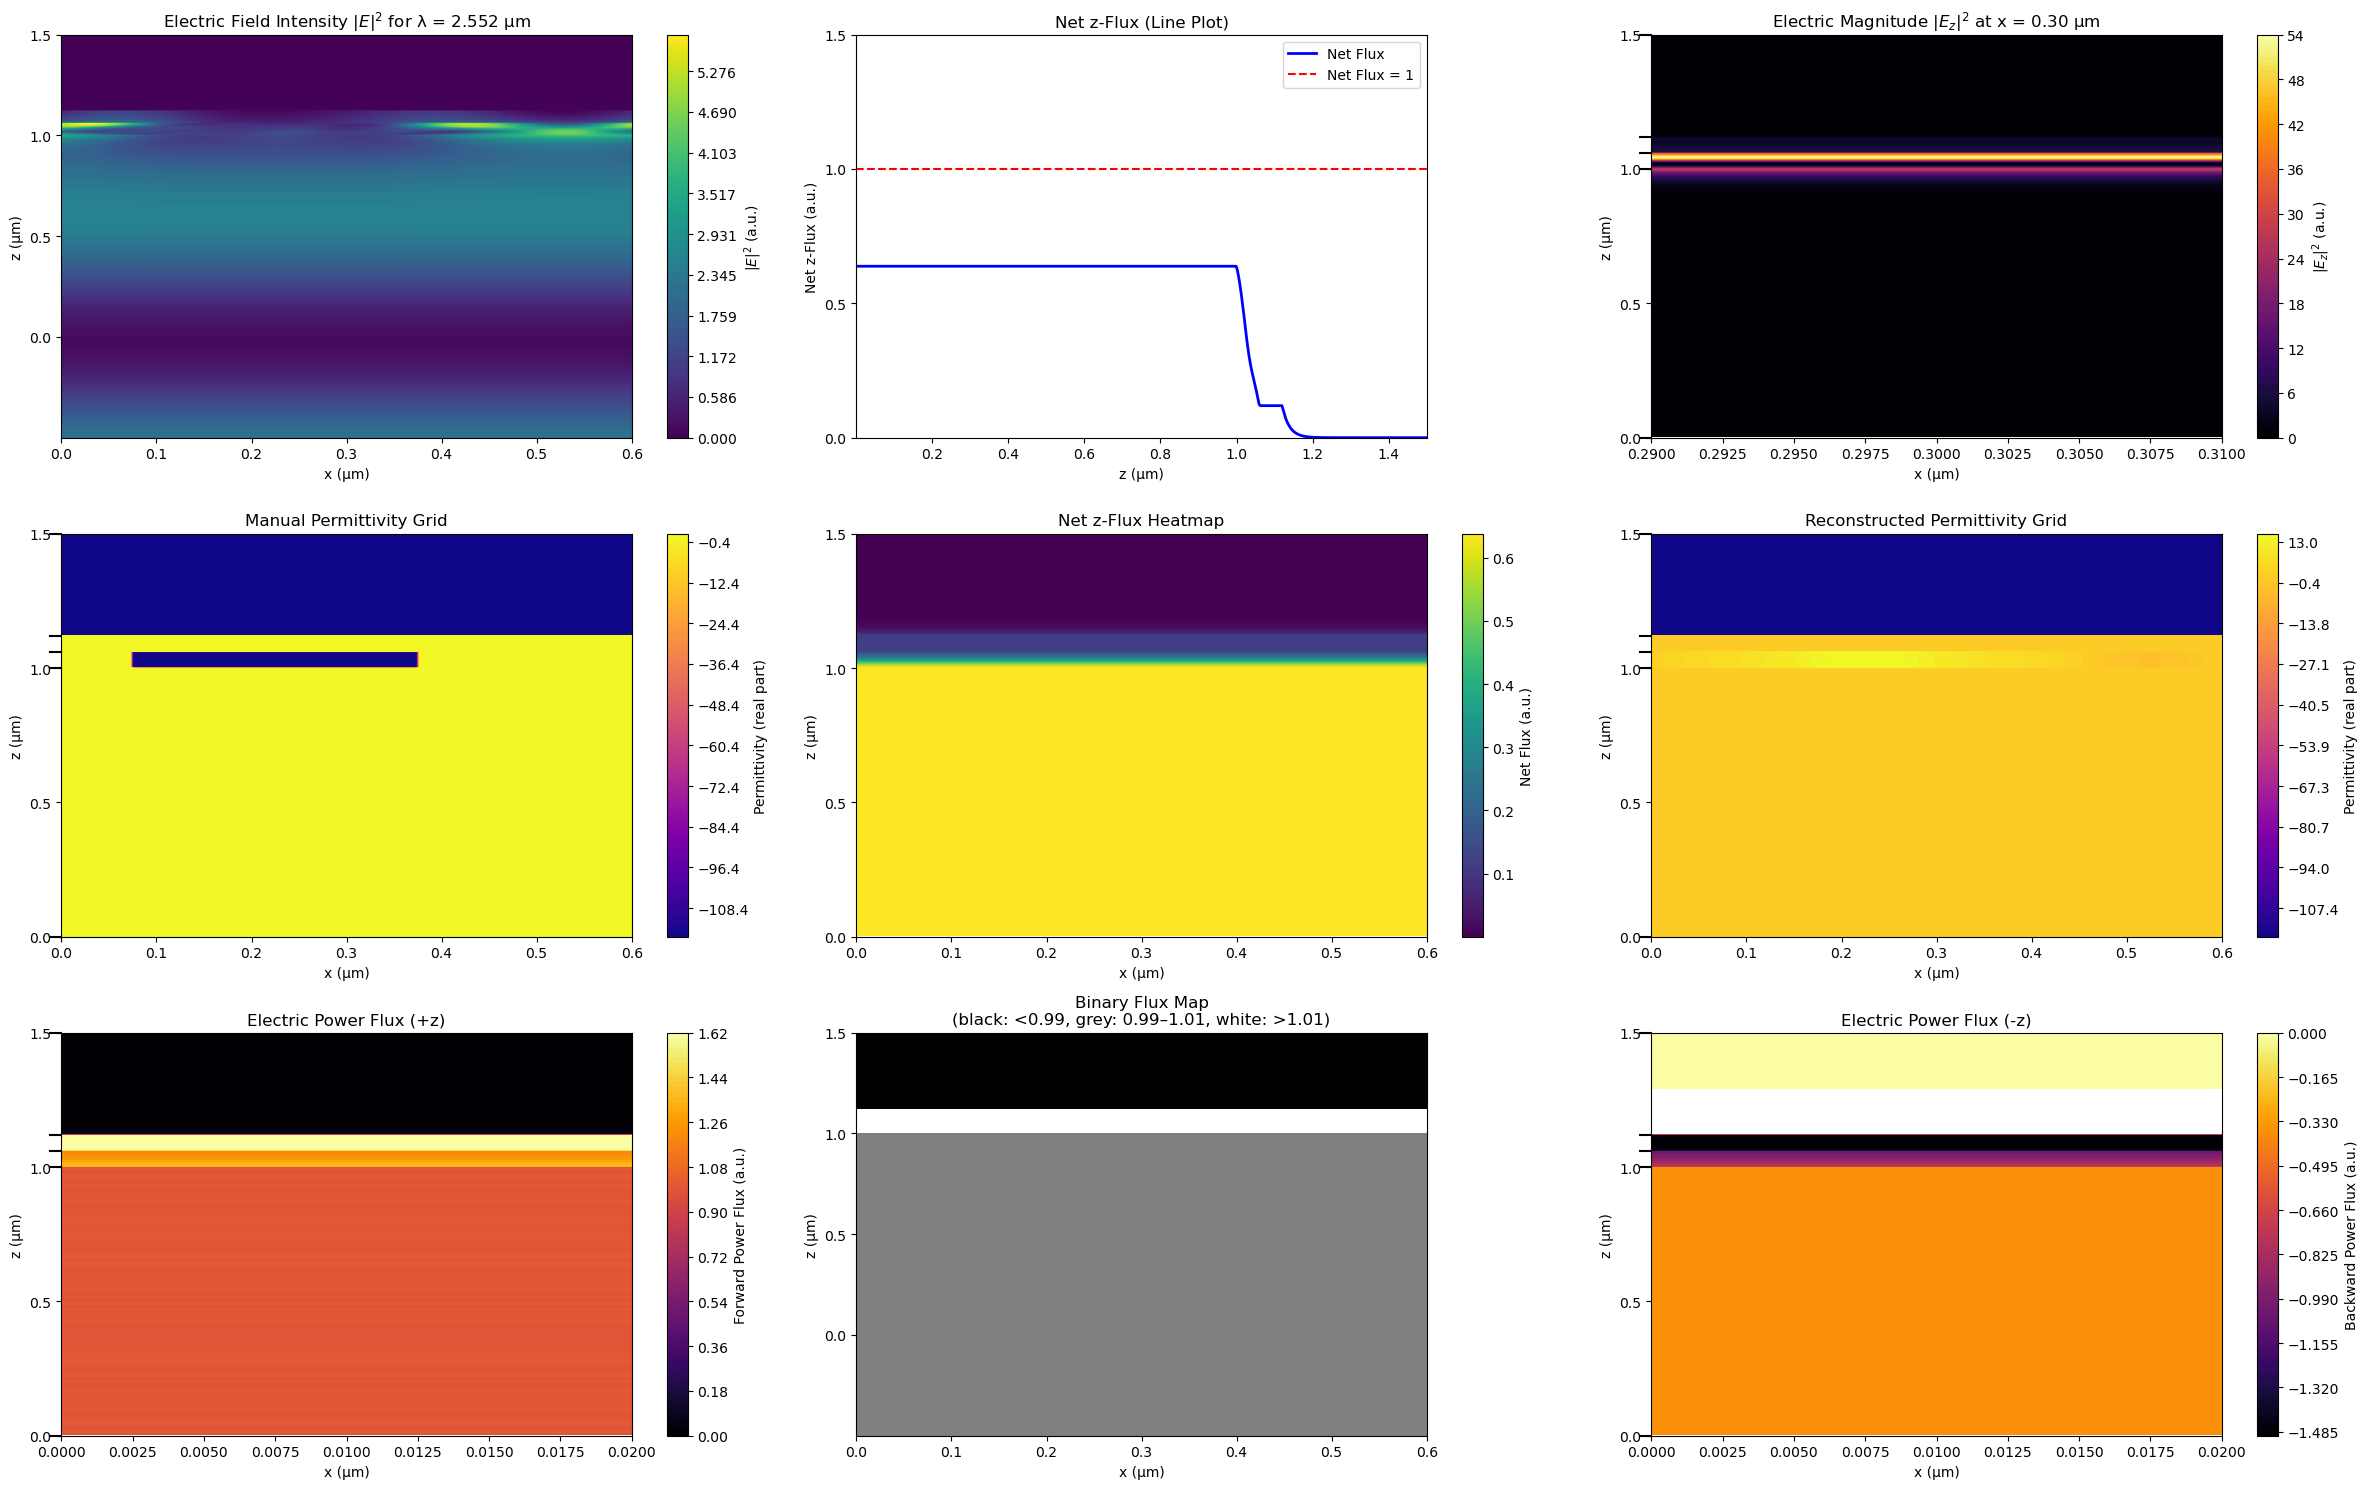

In [11]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# Prepare the figure for a 3x3 layout
fig = plt.figure(figsize=(24, 15))
gs = gridspec.GridSpec(nrows=3, ncols=3, figure=fig)

# ─────────────────────────────────────────────────────
# Row 0, Col 0 → Electric Field Intensity |E|²
# ─────────────────────────────────────────────────────
ax_e_field = fig.add_subplot(gs[0, 0])
levels = np.linspace(np.min(electric_field_magnitude), np.max(electric_field_magnitude), 100)
cf1 = ax_e_field.contourf(x_space, z_space, electric_field_magnitude,
                          levels=levels, cmap='viridis')
ax_e_field.set_xlabel("x (µm)")
ax_e_field.set_ylabel("z (µm)")
ax_e_field.set_title(f"Electric Field Intensity $|E|^2$ for λ = {wavelength:.3f} µm")
ax_e_field.set_xlim(x_space[0], x_space[-1])
ax_e_field.set_ylim(z_min, z_max)
ax_e_field.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf1, ax=ax_e_field, label=r"$|E|^2$ (a.u.)")

# ─────────────────────────────────────────────────────
# Row 0, Col 1 → Net z-Flux (Line Plot)
# ─────────────────────────────────────────────────────
ax_net_line = fig.add_subplot(gs[0, 1])
ax_net_line.plot(z_common_other, net_flux_other, color='blue', linewidth=2, label='Net Flux')
ax_net_line.axhline(y=1, color='red', linestyle='--', linewidth=1.5, label='Net Flux = 1')
ax_net_line.set_xlabel("z (µm)")
ax_net_line.set_ylabel("Net z-Flux (a.u.)")
ax_net_line.set_title("Net z-Flux (Line Plot)")
ax_net_line.set_xlim(z_common_other[0], z_common_other[-1])
ax_net_line.set_ylim(0, max(net_flux_other)*1.1)
ax_net_line.set_yticks([0.0, 0.5, 1.0, 1.5])
ax_net_line.legend()

# ─────────────────────────────────────────────────────
# Row 0, Col 2 → Electric Magnitude |E_z|² (x = p/2)
# ─────────────────────────────────────────────────────
ax_ez = fig.add_subplot(gs[0, 2])
cf_ez = ax_ez.contourf(x_flux_field, z_space_other, flux_2d_field_other, levels=100, cmap='inferno')
ax_ez.set_xlabel("x (µm)")
ax_ez.set_ylabel("z (µm)")
ax_ez.set_title(f"Electric Magnitude $|E_z|^2$ at x = {x_center:.2f} µm")
ax_ez.set_xlim(x_flux_field[0], x_flux_field[-1])
ax_ez.set_ylim(0, z_max)
ax_ez.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_ez, ax=ax_ez, label=r"$|E_z|^2$ (a.u.)")

# ─────────────────────────────────────────────────────
# Row 1, Col 0 → Manual Permittivity Grid (z≥0)
# ─────────────────────────────────────────────────────
ax_perm_manual = fig.add_subplot(gs[1, 0])
levels_eps = np.linspace(np.min(eps_map_manual_other), np.max(eps_map_manual_other), 100)
cf2 = ax_perm_manual.contourf(x_space, z_space_other, eps_map_manual_other,
                              levels=levels_eps, cmap='plasma')
ax_perm_manual.set_xlabel("x (µm)")
ax_perm_manual.set_ylabel("z (µm)")
ax_perm_manual.set_title("Manual Permittivity Grid")
ax_perm_manual.set_xlim(x_space[0], x_space[-1])
ax_perm_manual.set_ylim(0, z_max)
ax_perm_manual.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf2, ax=ax_perm_manual, label="Permittivity (real part)")

# ─────────────────────────────────────────────────────
# Row 1, Col 1 → Net z-Flux Heatmap
# ─────────────────────────────────────────────────────
ax_net_heat = fig.add_subplot(gs[1, 1])
cf_net_heat = ax_net_heat.imshow(net_flux_heat_other,
                                 aspect='auto',
                                 extent=[x_space[0], x_space[-1],
                                         z_common_other[0], z_common_other[-1]],
                                 origin='lower',
                                 cmap='viridis')
ax_net_heat.set_xlabel("x (µm)")
ax_net_heat.set_ylabel("z (µm)")
ax_net_heat.set_title("Net z-Flux Heatmap")
ax_net_heat.set_xlim(x_space[0], x_space[-1])
ax_net_heat.set_ylim(0, z_max)
ax_net_heat.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_net_heat, ax=ax_net_heat, label="Net Flux (a.u.)")

# ─────────────────────────────────────────────────────
# Row 1, Col 2 → Reconstructed Permittivity Grid (z≥0)
# ─────────────────────────────────────────────────────
ax_perm_recon = fig.add_subplot(gs[1, 2])
levels_eps2 = np.linspace(np.min(eps_map_reconstructed_other.real),
                          np.max(eps_map_reconstructed_other.real),
                          100)
cf3 = ax_perm_recon.contourf(x_space, z_space_other,
                             eps_map_reconstructed_other.real,
                             levels=levels_eps2, cmap='plasma')
ax_perm_recon.set_xlabel("x (µm)")
ax_perm_recon.set_ylabel("z (µm)")
ax_perm_recon.set_title("Reconstructed Permittivity Grid")
ax_perm_recon.set_xlim(x_space[0], x_space[-1])
ax_perm_recon.set_ylim(0, z_max)
ax_perm_recon.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf3, ax=ax_perm_recon, label="Permittivity (real part)")

# ─────────────────────────────────────────────────────
# Row 2, Col 0 → Electric Power Flux (+z)
# ─────────────────────────────────────────────────────
ax_flux_plus = fig.add_subplot(gs[2, 0])
cf_plus = ax_flux_plus.contourf(x_flux, z_common_other, flux_2d_flux_other,
                                levels=100, cmap='inferno')
ax_flux_plus.set_xlabel("x (µm)")
ax_flux_plus.set_ylabel("z (µm)")
ax_flux_plus.set_title("Electric Power Flux (+z)")
ax_flux_plus.set_xlim(x_flux[0], x_flux[-1])
ax_flux_plus.set_ylim(0, z_max)
ax_flux_plus.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_plus, ax=ax_flux_plus, label="Forward Power Flux (a.u.)")

# ─────────────────────────────────────────────────────
# Row 2, Col 1 → Binary Flux Map
# ─────────────────────────────────────────────────────
ax_bin = fig.add_subplot(gs[2, 1])
ax_bin.imshow(binary_data, aspect='auto',
              extent=[x_space[0], x_space[-1], z_min, z_max],
              origin='lower', interpolation='none',
              cmap=binary_cmap)
ax_bin.set_xlabel("x (µm)")
ax_bin.set_ylabel("z (µm)")
ax_bin.set_title("Binary Flux Map\n(black: <0.99, grey: 0.99–1.01, white: >1.01)")
ax_bin.set_xlim(x_space[0], x_space[-1])
ax_bin.set_ylim(z_min, z_max)
ax_bin.set_yticks([0.0, 0.5, 1.0, 1.5])

# ─────────────────────────────────────────────────────
# Row 2, Col 2 → Electric Power Flux (-z)
# ─────────────────────────────────────────────────────
ax_flux_minus = fig.add_subplot(gs[2, 2])
cf_minus = ax_flux_minus.contourf(x_flux, z_common_other,
                                  back_flux_2d_other, levels=100,
                                  cmap='inferno')
ax_flux_minus.set_xlabel("x (µm)")
ax_flux_minus.set_ylabel("z (µm)")
ax_flux_minus.set_title("Electric Power Flux (-z)")
ax_flux_minus.set_xlim(x_flux[0], x_flux[-1])
ax_flux_minus.set_ylim(0, z_max)
ax_flux_minus.set_yticks([0.0, 0.5, 1.0, 1.5])
fig.colorbar(cf_minus, ax=ax_flux_minus, label="Backward Power Flux (a.u.)")

# ─────────────────────────────────────────────────────
# Add hash-mark annotations on the left border
# of the lower subplots for layer boundaries.
# ─────────────────────────────────────────────────────
layer_boundaries = [0.0, 1.0, 1.06, 1.12, 1.5]
for ax in (ax_perm_manual, ax_perm_recon, ax_flux_plus, ax_flux_minus, ax_ez):
    for y in layer_boundaries:
        ax.plot([-0.02, 0], [y, y], color='black',
                transform=ax.get_yaxis_transform(),
                clip_on=False)

# Final layout
fig.tight_layout()
box = ax_net_line.get_position()   # get [left, bottom, width, height] in figure coords
ax_net_line.set_position([
    box.x0, 
    box.y0, 
    box.width * 0.8,   # for example, make it 30% of its original width
    box.height
])
box = ax_bin.get_position()   # get [left, bottom, width, height] in figure coords
ax_bin.set_position([
    box.x0, 
    box.y0, 
    box.width * 0.8,   # for example, make it 30% of its original width
    box.height
])
plt.savefig('field_analysis.png', dpi=1000, bbox_inches='tight')
